In [ ]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [1]:
import optax
import jax.numpy as jnp
import jax
import numpy as np


BATCH_SIZE = 5
NUM_TRAIN_STEPS = 1000
RAW_TRAINING_DATA = np.random.randint(255, size=(NUM_TRAIN_STEPS, BATCH_SIZE, 1))

In [3]:
# Raw Data:     (1000, 5, 1)   # 1000 steps, 5 samples per batch, 1 number
#    ↓
# Features:     (1000, 5, 8)   # Each number converted to 8 binary digits
# Labels:       (1000, 5, 2)   # One-hot encoded odd/even labels

TRAINING_DATA = np.unpackbits(RAW_TRAINING_DATA.astype(np.uint8), axis=-1)
LABELS = jax.nn.one_hot(RAW_TRAINING_DATA % 2, 2).astype(jnp.float32).reshape(NUM_TRAIN_STEPS, BATCH_SIZE, 2)

2024-11-27 19:23:04.372195: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
initial_params = {
    'hidden': jax.random.normal(shape=[8,32], key=jax.random.PRNGKey(0)),
    'output': jax.random.normal(shape=[32,2], key=jax.random.PRNGKey(1))
}

# can this be jitted?
def net(x: jnp.ndarray, params: optax.Params) -> jnp.ndarray:
    x = jnp.dot(x, params['hidden'])
    x = jax.nn.relu(x)
    x = jnp.dot(x, params['output'])
    return x

def loss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.array:
    y_hat = net(batch, params)

    loss_value = optax.sigmoid_binary_cross_entropy(y_hat, labels).sum(-1) # output dim: 2, sum over it to get scalar loss for each sample

    return loss_value.mean()

In [7]:
# test of the jit net
xs = jax.random.normal(jax.random.PRNGKey(0), (BATCH_SIZE, 8))
%timeit net(xs, initial_params)

net_jit = jax.jit(net)
%timeit net_jit(xs, initial_params)

76.1 μs ± 4.31 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
12.4 μs ± 527 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
# test of the jit loss
batch = jax.random.normal(jax.random.PRNGKey(0), (BATCH_SIZE, 8))
labels = jax.nn.one_hot(jax.random.randint(jax.random.PRNGKey(1), (BATCH_SIZE,), 0, 2), 2)
%timeit loss(initial_params, batch, labels)

loss_jit = jax.jit(loss)
%timeit loss_jit(initial_params, batch, labels)

242 μs ± 11.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
14.7 μs ± 392 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Step 0    , Loss: 9.6880e+00
Step 100  , Loss: 8.6947e-08
Step 200  , Loss: 6.4826e-06
Step 300  , Loss: 3.3934e-03
Step 400  , Loss: 7.2035e-06
Step 500  , Loss: 1.8127e-07
Step 600  , Loss: 7.5065e-05
Step 700  , Loss: 5.5715e-06
Step 800  , Loss: 2.8871e-06
Step 900  , Loss: 8.4047e-09
Final Loss: 7.6347e-05


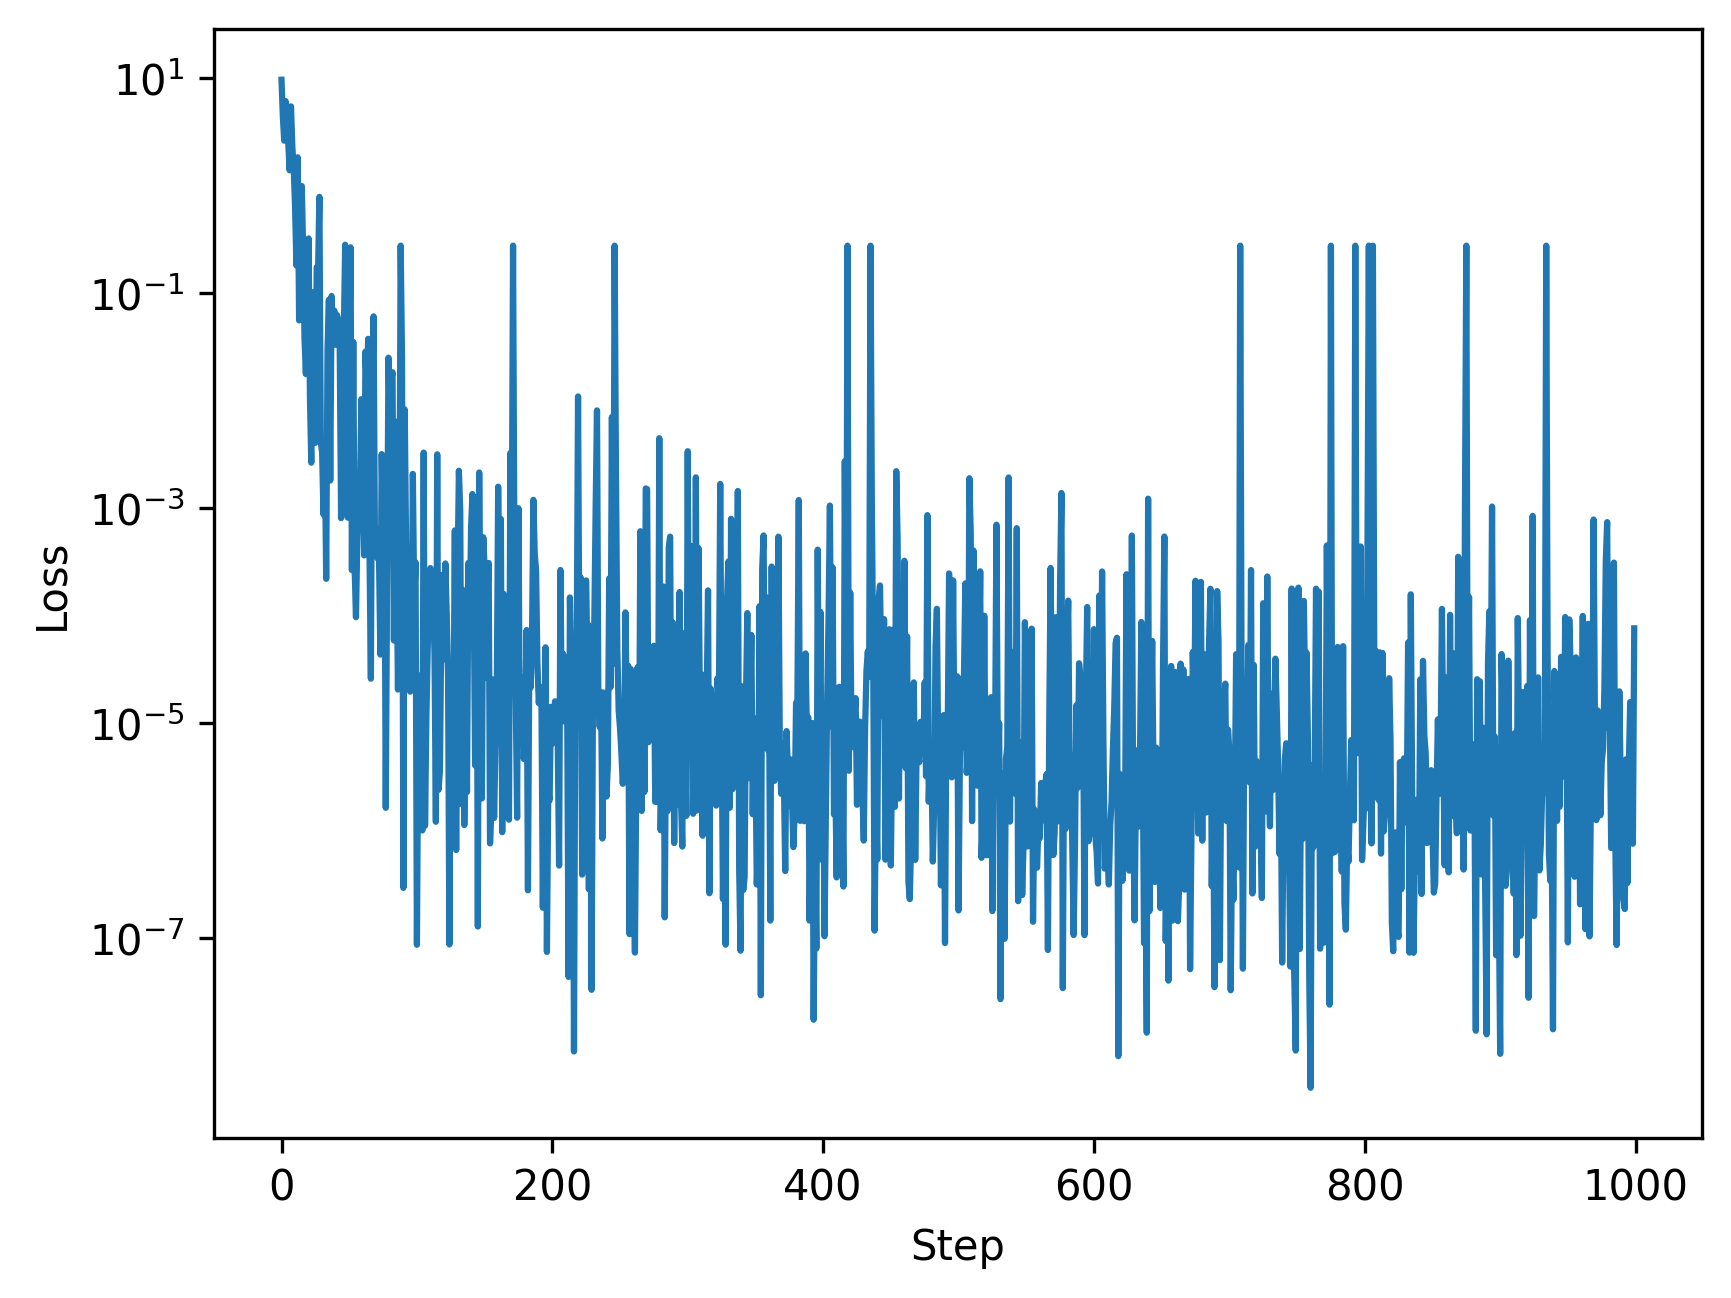

In [31]:
import matplotlib.pyplot as plt

def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)
    losses = []

    @jax.jit
    def step(params, opt_state, batch, labels):
        loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
        updates, opt_state = optimizer.update(grads, opt_state, params)   # optimizer loves grad!
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i, (batch, labels) in enumerate(zip(TRAINING_DATA, LABELS)):
        params, opt_state, loss_value = step(params, opt_state, batch, labels)
        losses.append(loss_value)
        if i % 100 == 0:
            print(f'Step {i:<5}, Loss: {loss_value:<8.4e}')

    print(f'Final Loss: {loss_value:<8.4e}')

    return params, losses

optimizer = optax.adam(learning_rate=1e-1)
params, losses = fit(initial_params, optimizer)

fig = plt.figure(dpi=300)
plt.plot(losses)
plt.xlabel('Step')
plt.yscale('log')
plt.ylabel('Loss')

plt.show()

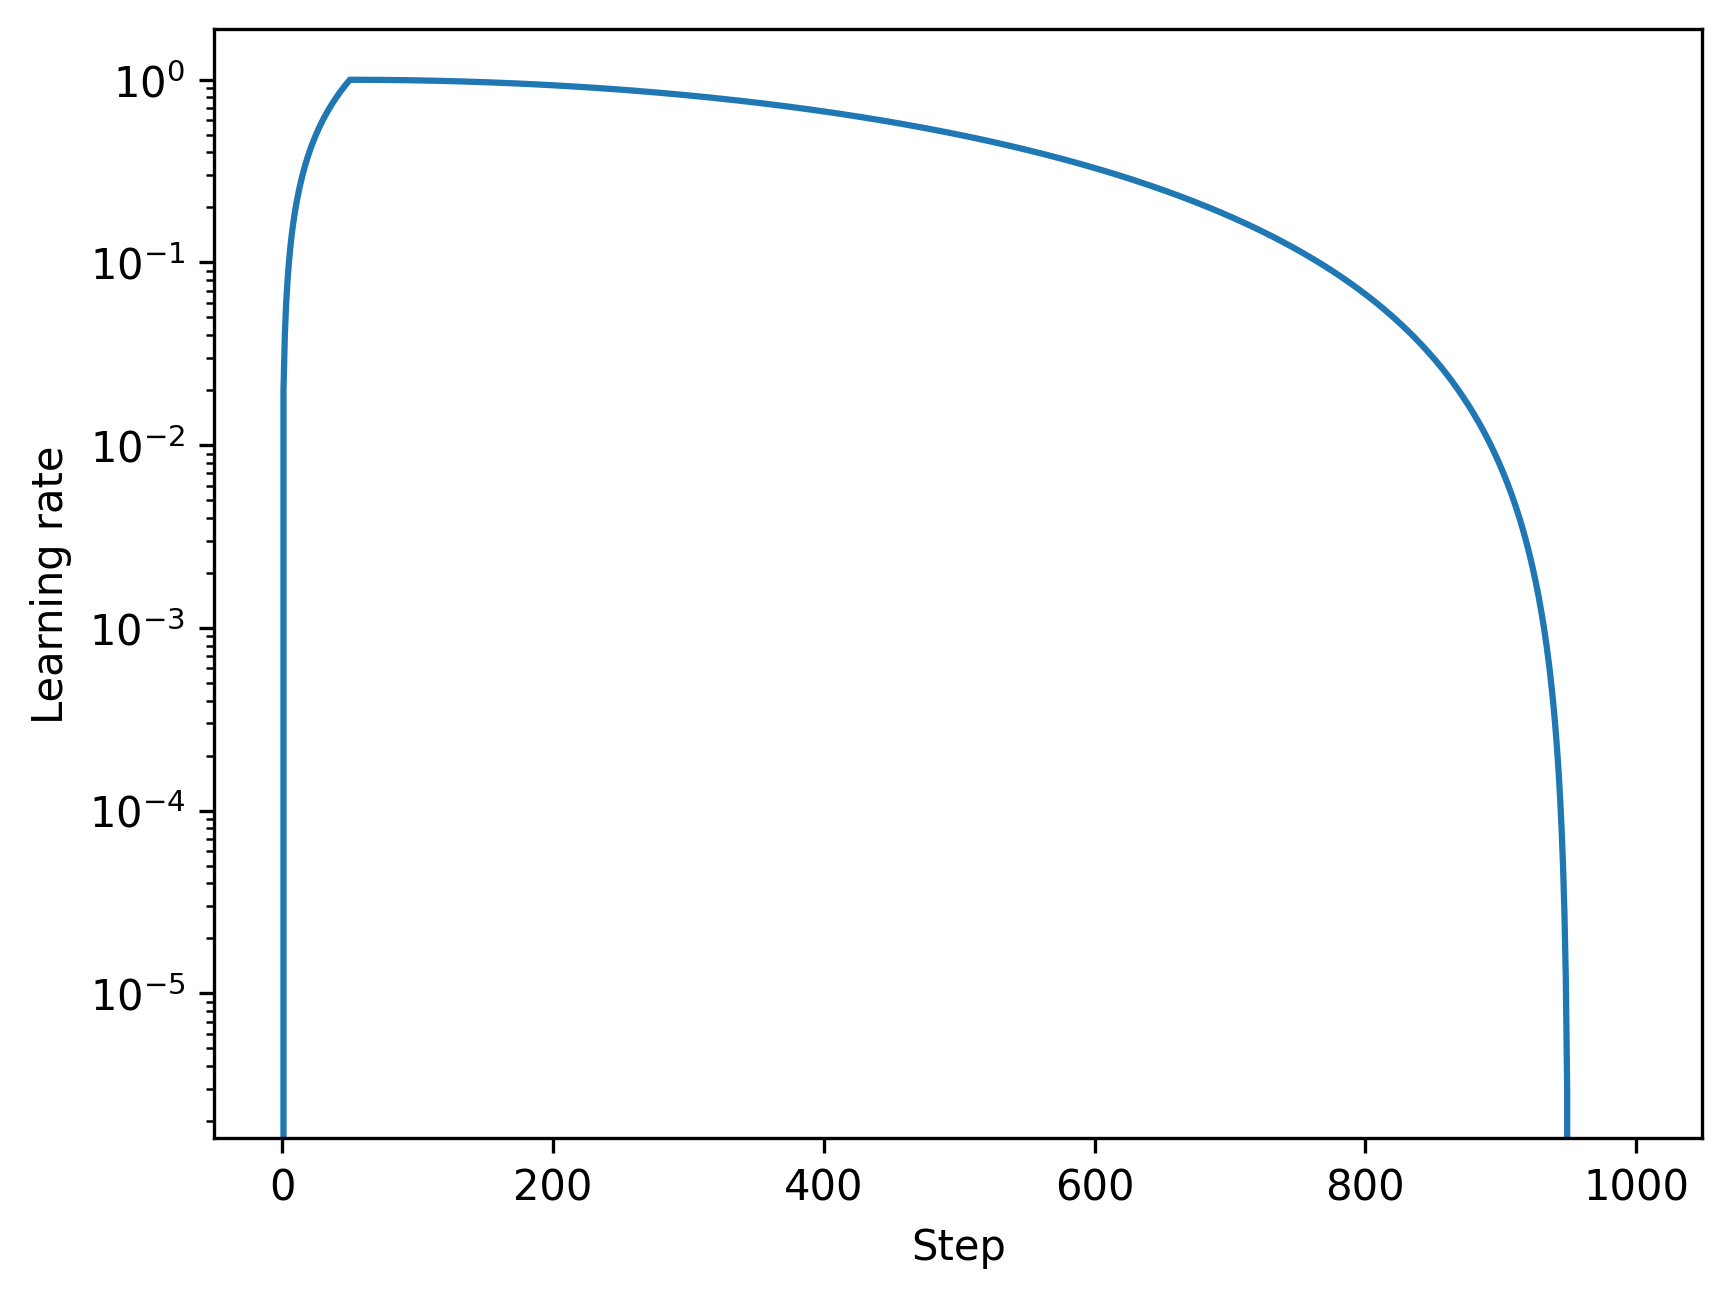

Step 0    , Loss: 9.6880e+00
Step 100  , Loss: 0.0000e+00
Step 200  , Loss: 3.7364e-22
Step 300  , Loss: 1.6752e-07
Step 400  , Loss: 1.6877e-24
Step 500  , Loss: 2.0196e-41
Step 600  , Loss: 1.3334e-14
Step 700  , Loss: 0.0000e+00
Step 800  , Loss: 1.5724e-16
Step 900  , Loss: 5.1316e-22
Final Loss: 1.8949e-06


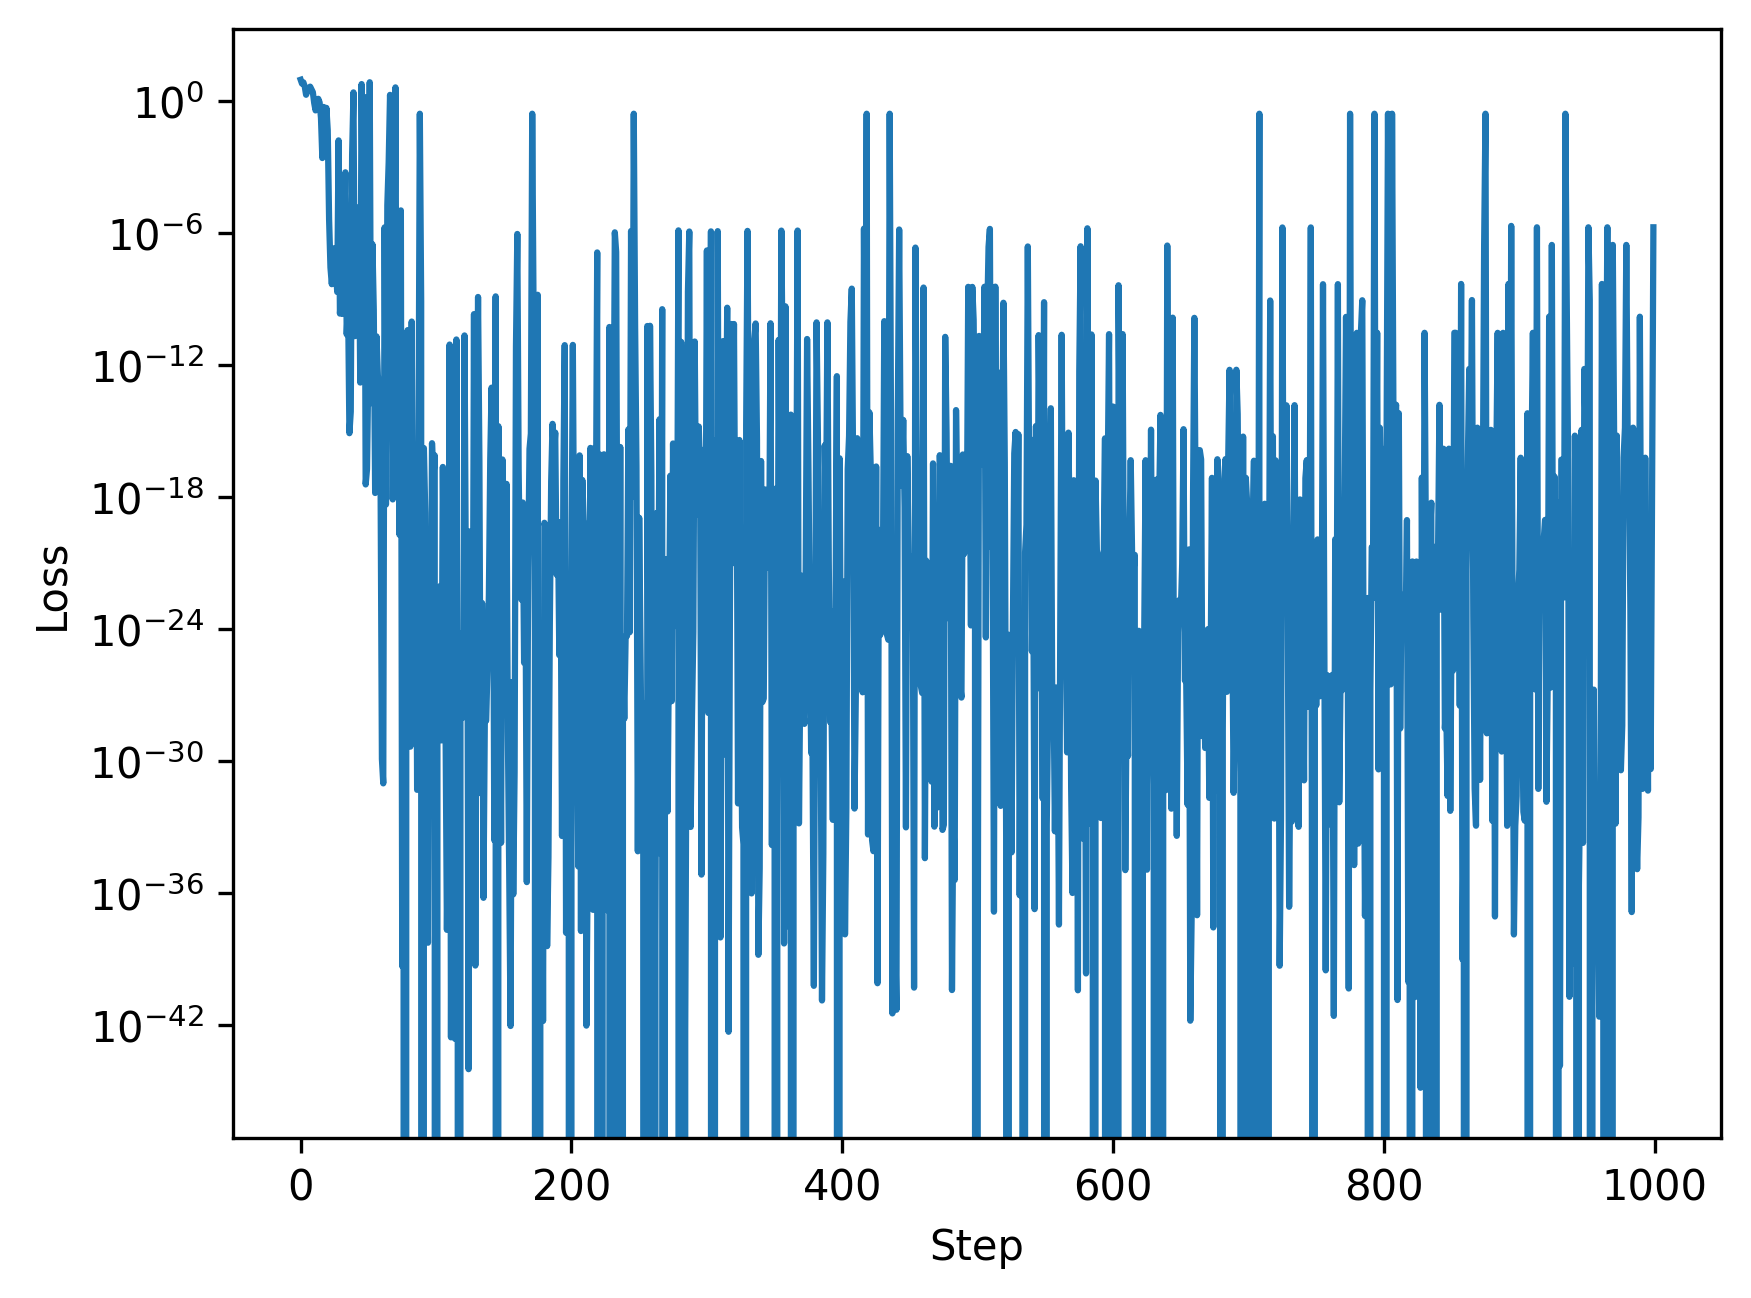

In [35]:
scheduler = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1.0,
    warmup_steps=50,
    decay_steps=950,
    end_value=0,
)

fig2 = plt.figure(dpi=300)
plt.plot(jax.vmap(scheduler)(jnp.arange(1000)))
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.yscale('log')
plt.show()

optimizer2 = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=scheduler),
)

params,losses = fit(initial_params, optimizer2)

fig = plt.figure(dpi=300)
plt.plot(losses)
plt.xlabel('Step')
plt.yscale('log')
plt.ylabel('Loss')

plt.show()

In [36]:
optax.flatten(optax.adam(1e-2))

GradientTransformationExtraArgs(init=<function flatten.<locals>.init_fn at 0x751bc01d9940>, update=<function flatten.<locals>.update_fn at 0x751bc01d9b20>)